In [1]:
%load_ext autoreload
%autoreload 2
from MachineLearning.dataset import *
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential, Model, optimizers, activations
from keras.layers import Reshape, Layer, Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, concatenate, Flatten, LeakyReLU, ReLU
import keras
import time
import keras
import numpy as np
import scipy
import glob

2024-04-10 11:06:35.849215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded packages


In [4]:
# compute means for the dataset

data_path = "/nesi/project/uoa03669/ewin313/storm_data/v2/"
file_paths = glob.glob(data_path + "*.hdf5")
print(file_paths)
compute_input_means(file_paths, "train", "./MachineLearning/")

['/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709079503.7059174.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709866163.992674.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709005773.32574.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709866163.9663055.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709868244.0205815.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709858189.7209415.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709866164.1364732.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709857271.7374938.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1708394465.7770813.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709869215.9944694.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709861375.4441903.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/v2/AllData_1709857997.612184.hdf5', '/nesi/project/uoa03669/ewin313/storm_data/

(array([[[4.62274374e-01, 4.35860415e-01, 4.07761740e-01, ...,
          6.01684726e-05, 0.00000000e+00, 0.00000000e+00],
         [6.84717213e-01, 6.41275579e-01, 5.98916974e-01, ...,
          2.40673890e-04, 0.00000000e+00, 0.00000000e+00],
         [9.15703972e-01, 8.54452468e-01, 7.97172082e-01, ...,
          7.22021671e-04, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[3.99277986e-01, 3.95547540e-01, 3.93561981e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.57460897e-01, 5.63778586e-01, 5.72924194e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       

In [4]:
from keras import Sequential, Model, optimizers, activations
from keras.layers import Reshape, Layer, Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, concatenate, Flatten, LeakyReLU, ReLU
import keras
def conv_prob_predictor(genesis_shape, movement_shape, num_outputs, output_bias, max_storms = 4):
    genesis_pca = Input(genesis_shape)
    movement_pca = Input(movement_shape)

    x = concatenate([genesis_pca, movement_pca])
    x = Dense(1000, activation=LeakyReLU())(x)
    x = Dense(2000, activation=LeakyReLU())(x)
    x = Dense(5000, activation=LeakyReLU())(x)
    x = Dense(2000, activation=LeakyReLU())(x)
    x = Dense(2000, activation=LeakyReLU())(x)
    x = Dense(num_outputs * max_storms, activation=LeakyReLU())(x)
    
    x = Reshape((num_outputs, max_storms))(x)
    
    #x = BatchNormalization()(x)
    #x = Dropout(.5)(x)
    output = Dense(max_storms, activation=activations.softmax, bias_initializer=output_bias)(x)


    model = Model(inputs=[genesis_pca, movement_pca], outputs=output)

    return model

In [5]:
class PredictCallback(keras.callbacks.Callback):
    def __init__(self, model, x,y):
        self.model = model
        self.x = x
        self.y = y

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        
        print('y predicted: ', y_pred)
        print('y true: ', self.y)
        #genesis, movement = self.x
        #print(movement[0] - movement[1])
        #print(outputs)
        #print(inputs[0] - inputs[1])
        '''for elem in self.x:
            (gen_matrix, _), output = elem
            #print(np.max(gen_matrix))
            #print(np.mean(gen_matrix))
            print('y true: ', output) '''
            

In [6]:
import cProfile
data_folder = "/nesi/project/uoa03669/ewin313/storm_data/v2/"
train_data = get_dataset(data_folder, "MachineLearning/ConvProbPredictor/", data_version=2, zero_inputs=False)
one_train_sample = next(iter(train_data))
cce = keras.losses.CategoricalCrossentropy()

minimum_entropy = 0
n_samples = 0
for sample in iter(train_data):
    inp, out = sample
    minimum_entropy += cce(out, out)
    n_samples += 1

print(minimum_entropy / n_samples)
    

2024-04-10 11:07:32.867455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


create dataset time: 0.06248617172241211
tf.Tensor(0.48743713, shape=(), dtype=float32)


In [5]:

def compute_pca_variance(file_paths, dataset):
    
    genesis_pca_variance = []
    movement_pca_variance =[]
    movement_pcas = []
    genesis_pcas = []
    
    for file_path in file_paths:
         with h5py.File(file_path, 'r') as file:
                movement_pcas += file[dataset + "_movement_pca"]
                genesis_pcas += file[dataset + '_genesis_pca']
                
                
    return np.var(movement_pcas, axis=0), np.var(genesis_pcas, axis=0)
print(compute_pca_variance(glob.glob( "/nesi/project/uoa03669/ewin313/storm_data/v2/*.hdf5"), 'train'))

(array([3.4283376, 3.3716142, 1.6566061, 0.6511952], dtype=float32), array([80.61528 , 12.157899, 21.638681, 20.021175], dtype=float32))


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_input, train_output = one_train_sample

# try standardizing and decorrelating the inputs
    

#scaler = StandardScaler()
#scaler.fit(train_input)
#train_input_sc = scaler.transform(train_input[0])

pca = PCA(n_components=4)
pca.fit(tf.reshape(train_input[0], (32, -1)))

train_input_pca_0 = pca.transform(tf.reshape(train_input[0], (32, -1)))

pca_2 = PCA(n_components = 4)
pca.fit(tf.reshape(train_input[1], (32, -1)))

train_input_pca_1 = pca.transform(tf.reshape(train_input[1], (32, -1)))

train_input_transformed = (tf.convert_to_tensor(train_input_pca_0), tf.convert_to_tensor(train_input_pca_1))
one_train_sample_transformed = (train_input_transformed, train_output)
print(one_train_sample_transformed)

NameError: name 'one_train_sample' is not defined

In [42]:
from MachineLearning.dataset import computePCADecompForGeneratorV2
import seaborn as sns

folder_path = "/nesi/project/uoa03669/ewin313/storm_data/v2/"
file_paths = glob.glob(os.path.join(folder_path, "*.hdf5"))

genesis_pca, movement_pca = computePCADecompForGeneratorV2(file_paths, "train", n_components=30)

variance = genesis_pca.explained_variance_ratio_


Computing PCA
[6.80542309e-01 2.08879712e-01 5.37177440e-02 3.05322559e-02
 9.92603486e-04 8.42599351e-04 7.55204205e-04 7.35842707e-04
 6.44342897e-04 6.36388473e-04 5.72615999e-04 5.63322663e-04
 5.37809625e-04 5.01711131e-04 4.79491906e-04 4.45119858e-04
 4.36271796e-04 4.05467968e-04 3.82848807e-04 3.72262948e-04
 3.64635021e-04 3.62697117e-04 3.52527136e-04 3.47080434e-04
 3.26955393e-04 3.25000081e-04 3.22848669e-04 3.17629037e-04
 3.07614756e-04 2.95263997e-04]


TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.

[6.80542309e-01 2.08879712e-01 5.37177440e-02 3.05322559e-02
 9.92603486e-04 8.42599351e-04 7.55204205e-04 7.35842707e-04
 6.44342897e-04 6.36388473e-04 5.72615999e-04 5.63322663e-04
 5.37809625e-04 5.01711131e-04 4.79491906e-04 4.45119858e-04
 4.36271796e-04 4.05467968e-04 3.82848807e-04 3.72262948e-04
 3.64635021e-04 3.62697117e-04 3.52527136e-04 3.47080434e-04
 3.26955393e-04 3.25000081e-04 3.22848669e-04 3.17629037e-04
 3.07614756e-04 2.95263997e-04]
[0, 0.6805423085617867, 0.8894220205988377, 0.94313976460033, 0.9736720204587705, 0.9746646239443947, 0.9755072232950558, 0.976262427500151, 0.976998270206867, 0.9776426131040846, 0.9782790015765911, 0.9788516175755808, 0.9794149402381722, 0.979952749863089, 0.9804544609943986, 0.9809339529006975, 0.9813790727588825, 0.9818153445546586, 0.9822208125223486, 0.9826036613290154, 0.9829759242772298, 0.9833405592981884, 0.9837032564155483, 0.9840557835512584, 0.9844028639848088, 0.9847298193780184, 0.9850548194587195, 0.98537766812778, 0.98

<Axes: >

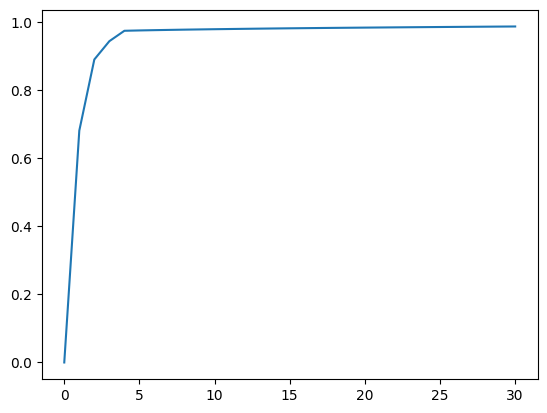

In [49]:
print(variance)

cumulative_variance = [0]
for i,v in enumerate(variance):
    cumulative_variance.append(cumulative_variance[i] + v)
print(cumulative_variance)
sns.lineplot(cumulative_variance)

In [7]:
import time
import tensorflow as tf
import keras
import numpy as np
import cProfile
# use the same random seed for debugging determinism
tf.keras.utils.set_random_seed(
    0
)

def earth_mover_distance_squared(y_pred, y_true):
    ## From https://arxiv.org/pdf/1611.05916.pdf
    
    return tf.math.reduce_sum(tf.math.square((tf.math.cumsum(y_pred) - tf.math.cumsum(y_true))), axis=[-1, -2])
    

def train(data_folder, one_train_batch = None):
    train_time = time.time()
    
    #if one_train_batch is None:
    train_data = get_dataset(data_folder, "MachineLearning/ConvProbPredictor/", data_version=2, zero_inputs=False)
    test_data = get_dataset(data_folder, "MachineLearning/ConvProbPredictor/", data_version=2, dataset="test")
    validation_data = get_dataset(data_folder, "MachineLearning/ConvProbPredictor/", data_version=2, dataset="validation")
    
    initial_biases = np.load('MachineLearning/ConvProbPredictor/initial_biases_new.npy')
    print(initial_biases)
    counts = np.exp(initial_biases)
    total_counts = np.sum(counts)
    weighted_counts = counts / total_counts
    
    #expected_loss = -np.sum(weighted_counts * np.log(weighted_counts))
    #weighted_biases = np.log(weighted_counts)

    # update this!
    genesis_shape = (4,)#(55, 105, 1)
    movement_shape = (4,) #(11,13)
    num_outputs = 1

    save_path = "models/site_prob_discrete_{}.weights.h5".format(str(train_time))
    
    early_stopping = keras.callbacks.EarlyStopping(patience=5)
    checkpoint = keras.callbacks.ModelCheckpoint(save_path, save_best_only=True, save_weights_only=True, mode='min', verbose=1)
    model = conv_prob_predictor(genesis_shape, movement_shape, num_outputs, None)
    inp, out =  one_train_batch
    #print(inp, out)
    predict_callback = PredictCallback(model,inp, out)
    # TODO: add CPRS metric
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00001), # LR 0.0001 worked well for fitting 2 points
        loss=earth_mover_distance_squared
    )
    
    #ntrain_input, ntrain_output = one_train_batch
    # try standardizing and decorrelating the inputs
    #print(ntrain_input)
    #model.evaluate(train_data, verbose=2)
    #print("expected_loss: {}".format(expected_loss))

    model.fit(inp, \
              out, \
              epochs=100, \
              validation_data=validation_data, \
              verbose=2, \
              callbacks=[checkpoint, predict_callback] \
    )
    
    #logits = model.predict(train_data, verbose=2)
    #probs = scipy.special.softmax(logits)
    #for elem in train_data.take(1):
        #(gen_matrix, _), output = elem
        #print(np.max(gen_matrix))
        #print(np.mean(gen_matrix))
        #print(gen_matrix)
        #print(output)
    #print(probs)

    
    #model.evaluate(
       # test_data,
      #  verbose=2
    #)

    #model.save_weights("models/site_prob_{}.weights.h5".format(str(time.time())))
    #model.save('models/site_prob_{}.keras'.format(str(time.time())))

In [8]:
train("/nesi/project/uoa03669/ewin313/storm_data/v2/", one_train_sample)

create dataset time: 0.025087833404541016
create dataset time: 0.04099249839782715
create dataset time: 0.03858828544616699
[  -0.14329314   -2.1202636    -4.3820267    -6.9077554  -100.
 -100.        ]
Epoch 1/100

Epoch 1: val_loss improved from inf to 135.54033, saving model to models/site_prob_discrete_1712704053.6129234.weights.h5
1/1 [==============================] - 0s 189ms/step
y predicted:  [[[0.1119964  0.21947487 0.48734856 0.18118015]]

 [[0.10957753 0.22033848 0.48834026 0.18174365]]

 [[0.10850775 0.22171609 0.48855582 0.18122031]]

 [[0.1096736  0.22048344 0.48770502 0.18213795]]

 [[0.11170275 0.2203559  0.49084008 0.17710137]]

 [[0.1082354  0.22129646 0.4895052  0.18096286]]

 [[0.11111314 0.21813497 0.49406323 0.17668876]]

 [[0.10965372 0.22116287 0.49102843 0.17815502]]

 [[0.1086676  0.22183864 0.48970708 0.17978665]]

 [[0.10864347 0.22263941 0.48861292 0.18010424]]

 [[0.11226422 0.21674094 0.4914814  0.17951356]]

 [[0.10950252 0.22149123 0.4876642  0.1813420

In [36]:
inp, out = one_train_sample

print(inp)

(<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[ 26.61666   ,   0.44498268,   9.523598  ,  -9.108036  ],
       [ 24.071962  ,  -2.3813677 ,  16.695292  , -18.449232  ],
       [  8.917374  ,  -0.31544852,   6.889626  ,  -8.461837  ],
       [ 28.294514  ,  -1.4519972 ,  11.799754  , -11.48335   ],
       [ 25.080246  ,   2.0860286 ,   8.141361  ,  -7.010829  ],
       [  6.068068  ,   0.43737283,   9.096702  ,  -9.243583  ],
       [ 19.34656   ,   0.8601095 ,  11.741958  , -10.981044  ],
       [ 13.912246  ,   1.6136199 ,   7.2206407 ,  -7.251426  ],
       [ 13.406931  ,   1.809654  ,   8.576286  ,  -7.3432302 ],
       [ 14.76575   ,   0.7933225 ,  10.118279  ,  -9.656548  ],
       [  8.009789  ,   0.71303976,  11.218399  , -11.1277    ],
       [ 13.187527  ,  -0.20479192,   4.8963947 ,  -5.591937  ],
       [ 18.70644   ,   1.6458907 ,  10.132897  ,  -8.888755  ],
       [ 16.58131   ,  -0.2123424 ,  10.104801  , -10.589632  ],
       [ 28.47195   ,   0.93111354,  10.

In [52]:
from MachineLearning.dataset import get_dataset
import numpy as np

def get_biases(one_train_batch):
    #train_data = get_dataset(data_path, data_version=2)
    val_counts = np.zeros((6,))
    k = 0
    train_inputs, train_outputs = one_train_batch
    print(train_outputs)
    summed_densities = np.sum(train_outputs, axis=0)

    
    avg_density = summed_densities / np.sum(summed_densities)
    print(avg_density)

    #otal_counts_per_site = np.sum(val_counts, axis = -1)
    
    #print(total_counts_per_site)
    
    #freq = val_counts / total_counts_per_site[:, None]
    #print(freq)
    log_avg_density = np.log(avg_density)
    print(log_avg_density < -100)
    log_avg_density[log_avg_density < -100] = -100
    print(log_avg_density)
    bias_prediction = scipy.special.softmax(log_avg_density)
    print(- np.sum( train_outputs * log_avg_density[None, :]) )
    #print(- np.sum( log_avg_density * avg_density ))
    np.save('MachineLearning/ConvProbPredictor/initial_biases_new.npy', log_avg_density)
    np.save('MachineLearning/ConvProbPredictor/expected_loss_new.npy', - np.sum( log_avg_density * avg_density ))
    #print(np.max(val_counts, axis=0))
    #print(np.min(val_counts))
    
        
get_biases(one_train_batch)

tf.Tensor(
[[0.911 0.084 0.005 0.    0.    0.   ]
 [0.822 0.156 0.02  0.002 0.    0.   ]], shape=(2, 6), dtype=float32)
[0.8665 0.12   0.0125 0.001  0.     0.    ]
[False False False False  True  True]
[  -0.14329314   -2.1202636    -4.3820267    -6.9077554  -100.
 -100.        ]
0.88055646


/dev/shm/jobs/44402243/ipykernel_139583/664330180.py:22: RuntimeWarning: divide by zero encountered in log
  log_avg_density = np.log(avg_density)


In [26]:

def make_site_predictions(data_folder, weight_path, prediction_save_folder, index=0):
    print("getting data")

    train_data = get_dataset(data_folder, "MachineLearning/ConvProbPredictor/", data_version=2, dataset="test").take(1000)

    print("loading model")

    genesis_shape = (4,)
    movement_shape = (4,)
    num_outputs = 1
    initial_biases = np.load('MachineLearning/ConvProbPredictor/initial_biases_new.npy')

    model = conv_prob_predictor(genesis_shape, movement_shape, num_outputs, None)

    model.load_weights(weight_path)

    samples = [item for i, item in enumerate(train_data.as_numpy_iterator()) if i < 10]

    # group outputs by the input genesis matrix
    outputs = [samples[i][1][j] for i in range(len(samples)) for j in range(len(samples[i][1]))]

    print(outputs)
    print("making predictions")

    predictions = model.predict(
        train_data,
        batch_size=1,
        verbose=2,
        steps=1
    )
    
    np.save(os.path.join(prediction_save_folder, "model_predictions{}.npy".format(index)), predictions)
    np.save(os.path.join(prediction_save_folder, "real_outputs{}.npy".format(index)), outputs)

    return predictions, outputs

make_site_predictions("/nesi/project/uoa03669/ewin313/storm_data/v2/", "/nesi/project/uoa03669/ewin313/TropicalCycloneAI/models/site_prob_discrete_1712630188.1991909.weights.h5", "/nesi/project/uoa03669/ewin313/TropicalCycloneAI/MachineLearning/ConvProbPredictor/predictions", 9)

getting data
create dataset time: 0.025968074798583984
loading model
[array([[0.815, 0.178, 0.007, 0.   ]], dtype=float32), array([[0.546, 0.351, 0.085, 0.018]], dtype=float32), array([[0.669, 0.277, 0.047, 0.007]], dtype=float32), array([[0.484, 0.372, 0.127, 0.017]], dtype=float32), array([[0.326     , 0.404     , 0.201     , 0.06900001]], dtype=float32), array([[0.596, 0.324, 0.068, 0.012]], dtype=float32), array([[0.73 , 0.237, 0.033, 0.   ]], dtype=float32), array([[0.656, 0.292, 0.05 , 0.002]], dtype=float32), array([[0.473, 0.37 , 0.131, 0.026]], dtype=float32), array([[0.521, 0.362, 0.097, 0.02 ]], dtype=float32), array([[0.812, 0.172, 0.016, 0.   ]], dtype=float32), array([[0.601, 0.315, 0.076, 0.008]], dtype=float32), array([[0.558, 0.374, 0.064, 0.004]], dtype=float32), array([[0.588, 0.336, 0.062, 0.014]], dtype=float32), array([[0.507, 0.387, 0.094, 0.012]], dtype=float32), array([[0.498, 0.394, 0.095, 0.013]], dtype=float32), array([[0.501, 0.367, 0.113, 0.019]], dtype=fl

(array([[[ 13.246447  ,  10.961876  ,   4.1309676 , -10.409399  ]],
 
        [[  9.639497  ,   7.805838  ,   2.4040544 ,  -8.251847  ]],
 
        [[  8.660986  ,   6.6775393 ,  -0.04852229, -10.428964  ]],
 
        [[ 17.350182  ,  14.908052  ,   8.03616   , -10.543263  ]],
 
        [[  8.961828  ,   7.4850025 ,   2.9718673 ,  -6.6782575 ]],
 
        [[ 15.074987  ,  12.387021  ,   3.9221113 , -12.986931  ]],
 
        [[  7.3396697 ,   5.521072  ,  -0.05271655,  -8.779601  ]],
 
        [[ 15.097338  ,  12.42      ,   5.183722  , -11.296589  ]],
 
        [[ 15.302988  ,  12.759781  ,   6.5081763 ,  -9.770758  ]],
 
        [[ 15.330121  ,  13.014491  ,   4.526006  , -12.53331   ]],
 
        [[ 15.975536  ,  13.296914  ,   5.607124  , -11.825323  ]],
 
        [[ 14.102104  ,  11.624132  ,   4.752834  , -10.690406  ]],
 
        [[ 14.135451  ,  11.720999  ,   4.900892  , -10.4918785 ]],
 
        [[  3.7591069 ,   2.521293  ,  -2.1431324 ,  -7.277753  ]],
 
        [[  6.824654

[[[9.07500625e-01 9.23996866e-02 9.97803290e-05 4.83329939e-11]]

 [[8.61661673e-01 1.37717441e-01 6.20903564e-04 1.46293413e-08]]

 [[8.78920615e-01 1.20934360e-01 1.45030193e-04 4.50079751e-09]]

 [[9.19907689e-01 8.00094083e-02 8.29308701e-05 7.07579774e-13]]

 [[8.12436521e-01 1.85529187e-01 2.03414843e-03 1.31034824e-07]]

 [[9.36300278e-01 6.36863187e-02 1.34209313e-05 6.08525600e-13]]

 [[8.59941959e-01 1.39528245e-01 5.29659213e-04 8.58932410e-08]]

 [[9.35632706e-01 6.43209442e-02 4.63101933e-05 3.22380490e-12]]

 [[9.26985621e-01 7.28739277e-02 1.40454300e-04 1.19586910e-11]]

 [[9.10146475e-01 8.98350850e-02 1.84902874e-05 7.21402051e-13]]

 [[9.35725927e-01 6.42447695e-02 2.93903340e-05 7.89566654e-13]]

 [[9.22509015e-01 7.74107054e-02 8.02849827e-05 1.57659406e-11]]

 [[9.17840540e-01 8.20698813e-02 8.95877820e-05 1.85034783e-11]]

 [[7.73534656e-01 2.24338591e-01 2.11431528e-03 1.24518128e-05]]

 [[8.10982943e-01 1.87594101e-01 1.42239325e-03 5.59048601e-07]]

 [[8.08567

<Axes: >

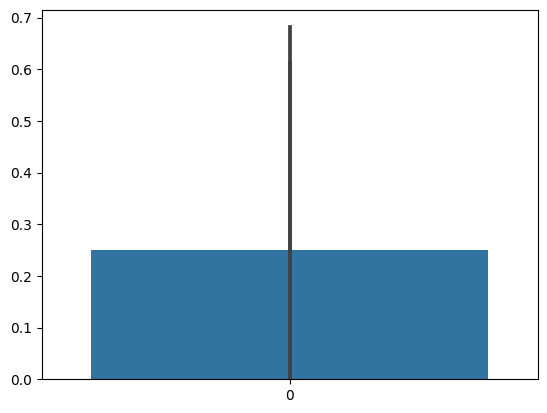

In [35]:
import seaborn as sns

predictions_path = "/nesi/project/uoa03669/ewin313/TropicalCycloneAI/MachineLearning/ConvProbPredictor/predictions/model_predictions9.npy"
real_output_path = "/nesi/project/uoa03669/ewin313/TropicalCycloneAI/MachineLearning/ConvProbPredictor/predictions/real_outputs9.npy"

predictions = np.load(predictions_path, allow_pickle=True)
real_outputs = np.load(real_output_path, allow_pickle=True)
print(scipy.special.softmax(predictions, axis=-1))
print(real_outputs)
sns.barplot(scipy.special.softmax(predictions[0])[0])
sns.barplot(real_outputs[0][0])

In [50]:
print(np.array([1, 2])[None,:] * np.array([[1,2],[2,2]]))

[[1 4]
 [2 4]]


In [7]:
def gener():
    a = [1, 2, 4]
    
    while len(a) > 0:
        yield a.pop()

In [3]:
print(gener())

<generator object gener at 0x2aaab721ba00>


In [8]:
[a for a in gener()]

[4, 2, 1]

In [5]:
[a for a in gener]

TypeError: 'function' object is not iterable

In [23]:
inp, out = one_train_sample
print(out)
cross = scipy.stats.entropy(out,axis=2)
print(np.mean(cross))

tf.Tensor(
[[[0.338 0.359 0.232 ... 0.    0.    0.   ]
  [0.913 0.087 0.    ... 0.    0.    0.   ]
  [1.    0.    0.    ... 0.    0.    0.   ]
  ...
  [0.278 0.356 0.244 ... 0.002 0.003 0.   ]
  [0.316 0.376 0.232 ... 0.003 0.    0.   ]
  [0.306 0.368 0.228 ... 0.002 0.001 0.   ]]], shape=(1, 530, 8), dtype=float32)
1.0981069


In [11]:
y_true = [[1. ,   0.  ,  0. ,   0.  ,]]
y_pred = [[7.60645568e-01 ,2.08485559e-01, 2.85796411e-02, 2.28918064e-03]]

# Using 'auto'/'sum_over_batch_size' reduction type.
cce = keras.losses.CategoricalCrossentropy()

cce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.192093e-07>

In [27]:
(0.13721842 + 1.1769392)/2

0.051293306 + 0.35667497

0.40796827599999996

In [24]:
tf.version

<module 'tensorflow._api.v2.version' from '/opt/nesi/CS400_centos7_bdw/TensorFlow/2.13.0-gimkl-2022a-Python-3.11.3/lib/python3.11/site-packages/tensorflow/_api/v2/version/__init__.py'>